# Assignment: 1  
# Linear Optimization
**Subject Code**: CS5040  
 

---


**CS24MTECH12014** : Abdulla Ovais

---

### Assumptions:
1. Polytope is non-degenerate.
2. Polytope is bounded.
3. Rank of A is `n`.
4. Initial feasible point is given

---

Implement the simplex algorithm to maximize the objective function, You need to implement the method discussed in class.

---

### Input:
- CSV file with `m + 2` rows and `n + 1` columns.
  - The **first row** excluding the last element is the initial feasible point `z` of length `n`
  - The **second row**, excluding the last element, is the cost vector `c` of length `n`.
  - The **last column**, excluding the top two elements, is the constraint vector `b` of length `m`.
  - **Rows third** to m+2 and **column one to n** is the matrix A of size m*n.

---

### Output:
You need to print the sequence of vertices visited and the value of the objective function at that vertex.

---

### Instructions:
1. You need to implement in google Collab and share the link
2. Implementation language is Python
3. Input CSV file name is Testcase.csv from Collab workspace.

In [320]:
import numpy as np
from sympy import Matrix, zoo
import matplotlib.pyplot as plt

In [321]:
class Assignment_1:
    def __init__(self, input_file):
        """
        Initialize the Assignment_1 class by loading data from the input CSV file.
        The input file contains:
        - Initial feasible point `z` (1st row, excluding the last element)
        - Cost vector `c` (2nd row, excluding the last element)
        - Constraint vector `b` (last column, excluding top two elements)
        - Coefficient matrix `A` (from 3rd row onwards, excluding the last column)

        Args:
            input_file (str): Path to the input CSV file.
        """
        try:
            data = np.genfromtxt(input_file, delimiter=',')
            self.z = data[0, :-1] # take only 1st row exclude last element
            self.c = data[1, :-1] # take only 2nd row exclude last element
            self.b = data[2:, -1] # from 3rd row to last row but take only last column excluding top 2 elements
            self.A = data[2:, :-1] # from 3rd row to last row but take all column except last column
            self.z_plot = []
        except FileNotFoundError:
            print(f"Error: File not found at {input_file}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def tight_rows_A(self):
        """
        Identify rows of A where the dot product with `z` equals the corresponding `b` value (tight constraints).

        Returns:
            np.ndarray: Rows of A corresponding to tight constraints.
        """
        tight = []
        for i in range(0, len(self.A), 1):
            if np.round(np.dot(self.A[i], self.z), 3) == np.round(self.b[i], 3):
                tight.append(self.A[i])
        return np.array(tight)

    def untight_rows_A(self):
        """
        Identify rows of A where the dot product with `z` does not equal the corresponding `b` value (untight constraints).

        Returns:
            np.ndarray: Rows of A corresponding to untight constraints.
        """
        untight = []
        for i in range(0, len(self.A), 1):
            if np.round(np.dot(self.A[i], self.z), 3) != np.round(self.b[i], 3):
                untight.append(self.A[i])
        return np.array(untight)

    def tight_rows_b(self):
        """
        Identify the `b` values corresponding to tight constraints.

        Returns:
            np.ndarray: Tight `b` values.
        """
        tight = []
        for i in range(0, len(self.A), 1):
            if np.round(np.dot(self.A[i], self.z), 3) == np.round(self.b[i], 3):
                tight.append(self.b[i])
        return np.array(tight)

    def untight_rows_b(self):
        """
        Identify the `b` values corresponding to untight constraints.

        Returns:
            np.ndarray: Untight `b` values.
        """
        untight = []
        for i in range(0, len(self.A), 1):
            if np.round(np.dot(self.A[i], self.z), 3) != np.round(self.b[i], 3):
                untight.append(self.b[i])
        return np.array(untight)

    def direction(self, towards="feasible"):
        """
        Compute the direction vector for moving towards feasibility or optimum.

        Args:
            towards (str): Either "feasible" or "optimum" to determine the direction type.

        Returns:
            np.ndarray: Direction vector.
        """
        direc = None
        if towards == "feasible":
            A1 = self.tight_rows_A()
            m = A1.shape[0]
            A1 = A1.reshape((m, self.A.shape[1]))
            space = np.array(Matrix(A1).nullspace())
            scale = np.random.randint(1, 4, space.shape[0]).reshape(space.shape[0], 1, 1)
            vec = np.array(np.sum(space * scale, axis = 0)).astype(float)
            direc = vec / np.linalg.norm(vec)
        elif towards == "optimum":
            A1_inversed_trans = np.transpose(
                            np.linalg.inv(self.tight_rows_A())
                         )
            for x in A1_inversed_trans:
                if np.dot((-1)*x, self.c.T) > 0:
                    direc = x.T
                    break
        return direc

    def step_size(self, u, towards="feasible"):
        """
        Calculate the step size to move in the given direction.

        Args:
            u (np.ndarray): Direction vector.
            towards (str): Either "feasible" or "optimum" to determine the step size type.

        Returns:
            float: Step size.
        """
        if towards == 'feasible':
            A2 = self.untight_rows_A()
            b2 = self.untight_rows_b()
            t = np.array([1e-16 if x == 0 else x for x in np.dot(A2 , u)])
            return min([a for a in ((b2 -np.dot(A2, self.z))/t.T)[0] if a > 0])
        elif towards == 'optimum':
            A2 = self.untight_rows_A()
            b2 = self.untight_rows_b()
            t = [1e-16 if x == 0 else x for x in np.dot(A2, u)]
            t1 = [x for x in (np.dot(A2, self.z) - b2)/t if x != zoo]
            return min([i for i in t1 if i >= 0])

    def move_toward_first_point(self):
        """
        Move towards the first feasible point from the initial point.

        Returns:
            np.ndarray: New feasible point.
        """
        u = self.direction(towards="feasible")
        alpha = self.step_size(u, towards='feasible')
        return (self.z + alpha * u.T)[0]

    def is_optimum(self):
        """
        Check if the current point is optimal.

        Returns:
            bool: True if the point is optimal, False otherwise.
        """
        A1 = self.tight_rows_A()
        A2 = self.untight_rows_A()
        return all([x >= 0 for x in np.dot(np.linalg.inv(A1.T), self.c.T)])

    def move_towards_optimum_point(self):
        """
        Move towards the optimum point from the current feasible point.

        Returns:
            np.ndarray: New point closer to optimum.
        """
        u = self.direction(towards="optimum")
        alpha = self.step_size(u, towards='optimum')
        return self.z - alpha * u

    def plot_z(self):
        """
        Plot the sequence of visited vertices in the feasible region.
        """
        x_values = [point[0][0] for point in self.z_plot]
        y_values = [point[0][1] for point in self.z_plot]
        plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', linewidth=2)
        plt.plot(x_values[0], y_values[0], marker='o', color='g', markersize=8, label="First Point")
        plt.plot(x_values[-1], y_values[-1], marker='o', color='r', markersize=8, label="Last Point")
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend()
        plt.show()

    def plot_c(self):
        """
        Plot the value of the objective function at each vertex.
        """
        c_values = [np.dot(item[0], item[1]) for item in self.z_plot]
        plt.plot(list(range(len(self.z_plot))), c_values, marker='o')
        plt.xlabel('Index in z_plot')
        plt.ylabel('Value of c')
        plt.show()

Vertex: [0. 0.] | Cost: 0.0
Vertex: [3. 0.] | Cost: 6.0
Vertex: [6.6 2.7] | Cost: 21.3




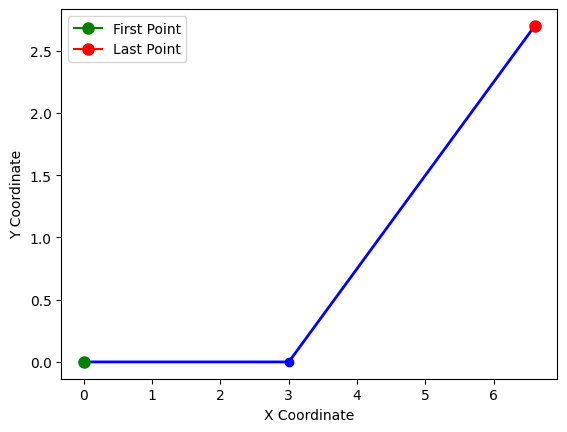

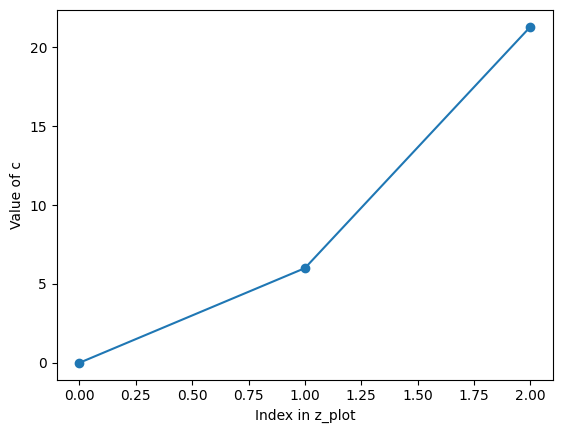

In [322]:
if __name__ == "__main__":
    try:
        # Create an instance of the Assignment_1 class by reading input from the CSV file.
        assignment = Assignment_1('Dataset_1.csv')

        # Check if the initial point z is feasible.
        # If any constraint is violated (i.e., np.matmul(A, z) > b), print an error message and exit.
        if not all(np.matmul(assignment.A, assignment.z) <= assignment.b):
            print("The problem is infeasible due to initial point.")
            exit(-1)
        else:
            # Ensure the rank of the tight rows of A matches the rank of the matrix A.
            # If not, move towards the first feasible point iteratively.
            while not np.linalg.matrix_rank(assignment.A) == assignment.tight_rows_A().shape[0]:
                assignment.z = assignment.move_toward_first_point()
            # Store the initial feasible point and its associated cost in the z_plot list for plotting later.
            assignment.z_plot.append([assignment.z, assignment.c])
            print(f"Vertex: {assignment.z} | Cost: {np.dot(assignment.z, assignment.c)}")

            # Continue the simplex algorithm until the optimal solution is reached.
            # At each iteration, move towards the optimum point and record the vertices and costs.
            while not assignment.is_optimum():
                assignment.z = assignment.move_towards_optimum_point()
                assignment.z_plot.append([assignment.z, assignment.c])
                print(f"Vertex: {assignment.z} | Cost: {np.dot(assignment.z, assignment.c)}")
            # Print the results and generate plots for the sequence of vertices and costs.
            print("\n")
            assignment.plot_z() # Plot the path of vertices visited.
            assignment.plot_c() # Plot the objective function values at each vertex.
    except Exception as e:
        print(f"An error occurred: {e}")
        exit(-1)